## 14. 인물 모드 문제점 찾기

### Step 1. 인물모드 직접 해 보기

- 첫번째 사진

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


In [2]:
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_img1.jpeg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(2448, 3264, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
            
        self.sess = tf.compat.v1.Session(graph=self.graph)
        
        #이미지 전처리하여 tensorflow 입력으로 사용 가능한 shape의 numpy array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)
            
        #Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict=(input...)) 방식을 활용
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict = {self.INPUT_TENSOR_NAME: [img_input]})
           
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(2448, 3264, 3) (384, 513, 3) 20


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

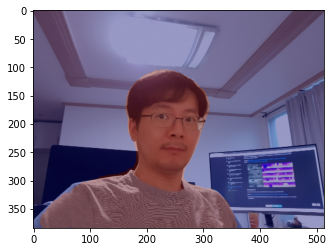

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람만 추출
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

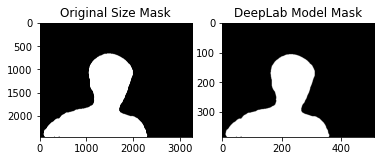

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

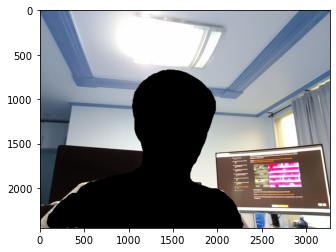

In [9]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

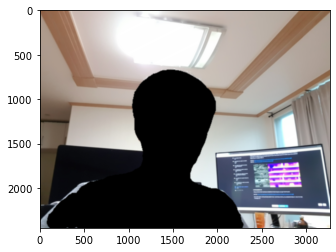

In [10]:
img_bg_blur = cv2.blur(img_bg, (13, 13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

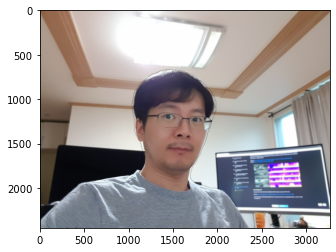

In [11]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 비교적 잘 된 것 같지만, 얼굴 주위에 경계선이 보이고, 블러 효과가 미미하다.

- 두번째 사진

In [12]:
import os
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_img2.jpeg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(3024, 4032, 3)


In [13]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(3024, 4032, 3) (384, 513, 3) 12


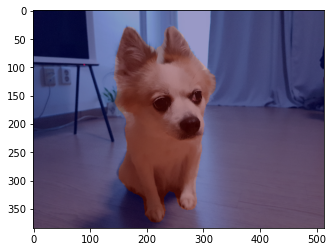

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # 강아지만 추출
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

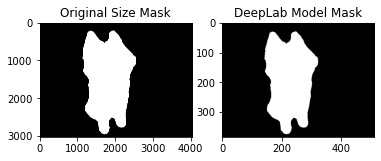

In [15]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()


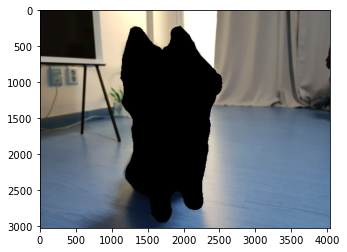

In [16]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

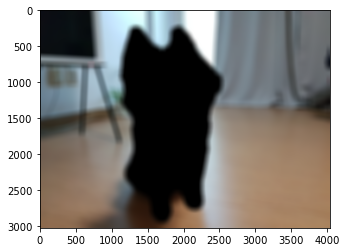

In [17]:
img_bg_blur = cv2.blur(img_bg, (97, 97))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


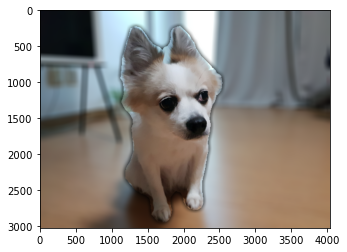

In [18]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 강아지만 추출해 보았고 blur 효과를 더욱 강하게 주었다. 강아지 경계선이 너무 잘 보이고 특히 귀사이는 경계선이 정확하지 않은 것을 알 수 있다.

- 세번째 사진

In [19]:
import os
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/my_img3.jpeg'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(2448, 3264, 3)


In [20]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(2448, 3264, 3) (384, 513, 3) 20


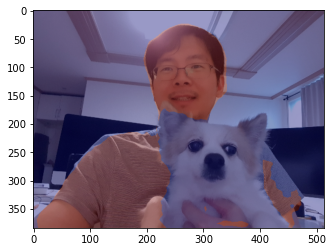

In [21]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 사람만 추출
img_mask = seg_map * (255 / seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

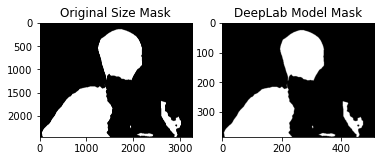

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

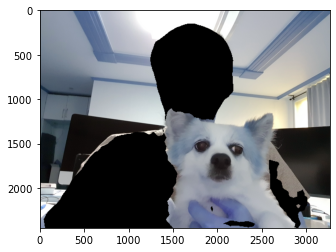

In [23]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

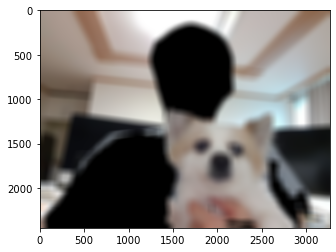

In [24]:
img_bg_blur = cv2.blur(img_bg, (97, 97))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

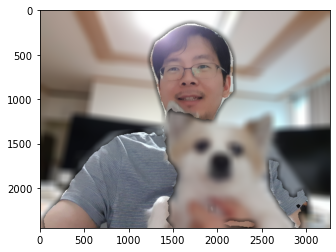

In [25]:
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- blur효과를 두번째 사진과 마찬가지로 주었더니, 경계선이 너무 잘 보여서 어색하다. 강아지는 빼고 추출한 것까지는 좋았는데 꼬리는 인식하지 못하고 남겨두었다.

- 첫번째 사진과 세번째 사진 합성하기

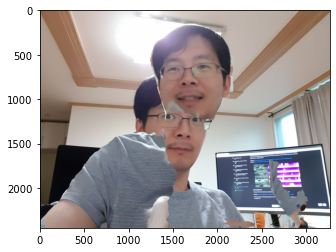

In [26]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.jpg' 
bg_img_orig = cv2.imread(bg_img_path)

img_resized = cv2.resize(
    img_orig, (bg_img_orig.shape[1], bg_img_orig.shape[0]))

img_mask_resized = cv2.resize(img_mask_color, (bg_img_orig.shape[1], bg_img_orig.shape[0]))

img_concat = np.where(
            img_mask_resized == 255, img_resized, bg_img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

### Step 2. 사진에서 문제점 찾기

- 배경사진 blur의 강도에 따른 윤곽선 문제: blur효과를 약하게 주면 배경이 그렇게 많이 흐릿하게 보이지 않아 효과가 없어보인다. blur를 강하게 주는 경우, 이때 사람의 윤곽을 따내고 그 자리를 검은색으로 처리하고 그 이미지에 blur를 주기 때문에 검은색이 윤곽보다 더 넓게 퍼진다. 그 위에 사람의 이미지를 얹으니 윤곽주위로 넓어진 검은색이 보여 어색하게 보인다.
- 강아지 사진 문제: 강아지의 경우 털이 있어 윤곽선을 정확하게 뜯어내지 못하는 것으로 보이며 특히 강아지 꼬리를 잘 인식하지 못하는 것으로 확인되었다. 
- 거리에 따른 문제: 세번째 사진에서처럼 강아지가 사람보다 앞에 있는 경우 우리가 원하는 바는 강아지가 배경처럼 흐릿하게 보이는 것은 아닐 것이다. 더군다나 이렇게 사람과의 거리가 미미한 경우 오히려 강아지도 또렷하게 보이는 사진을 원할 것이다.

### Step 3. 해결 방법을 제안해 보기

- 우리가 원하는 사진을 얻으려면 파사계 심도를 이해하여 사물간의 거리 정보를 확보하고 (이때 3D Depth Camera 혹은 Struct2Depth 등을 이용해 거리 정보를 구할 수 있음) 이를 통해 원근감에 따른 보케효과를 구현해야 할 것입니다.